In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math, torch, gpytorch

In [38]:
dim = 2
param_space = { 
    'min' : np.zeros(dim), 
    'max' : np.ones(dim)
}


In [26]:
import sys
sys.path.append("C:/Users/paolo/projects/thesis/code/")

In [27]:
from utils.utils import latin_hypercube_sampling as lhs

In [43]:
from models.forward import forward_model as fm
from models.GP_models.MTSurrogate import MTModel
from models.lipschitz import lipschitz_regressor

In [82]:
x = lhs( [0,0], [1,1], 60).reshape((-1,dim))

In [92]:
forward = fm(2, "U")
true = forward.predict(x)

In [93]:
noise_level = np.abs(np.random.normal(0, 0.2, size = len(true)) )
y = np.random.uniform(true.T-noise_level,true.T+ noise_level).T
train_y = np.random.normal(loc = true.T, scale = noise_level/2 ).T

In [94]:
x.shape

(60, 2)

In [95]:
# initialize likelihood and model

GP = MTModel()
GP.fit(x, train_y, noise = noise_level**2/4)


Iter = 200, Loss = -0.9545880781509071, Loss_ratio = None= None


In [96]:
test = np.linspace(0,1, 100)
x_test = test.reshape((-1,1) )

X, Y = np.meshgrid(test, test)
X = X.reshape((-1))
Y = Y.reshape((-1))
x_test = np.transpose([X,Y])

mean, std = GP.predict(x_test, return_std = True)

In [97]:
lips = lipschitz_regressor(x, y, noise_level)
pred, low_bd, up_bd = lips.predict(x_test, return_bds=True)

(10000, 60)


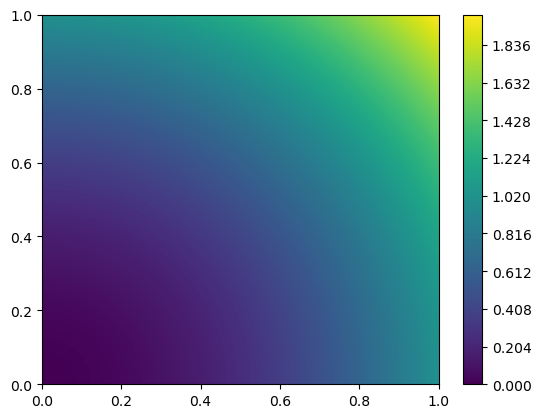

In [106]:
plt.contourf(test,test, np.reshape(forward.predict(x_test)[:,0], (100,100)), 500 )
plt.colorbar()

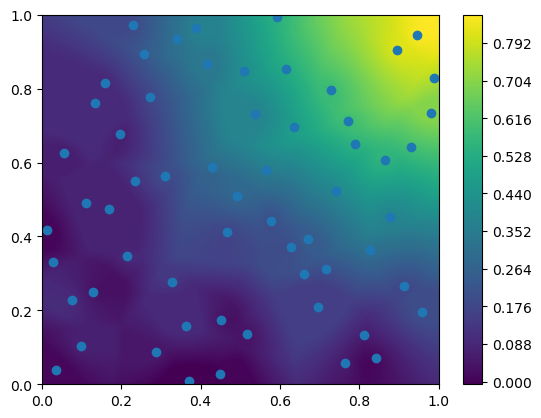

In [105]:
plt.contourf(test,test, np.reshape(pred[:,1], (100,100)),500 )
plt.colorbar()
plt.scatter(x[:,0], x[:,1])

In [63]:
pred.shape

(10000, 2)

In [18]:
meas = np.array( [[-0.4]])
eps_l = np.array([0.05])

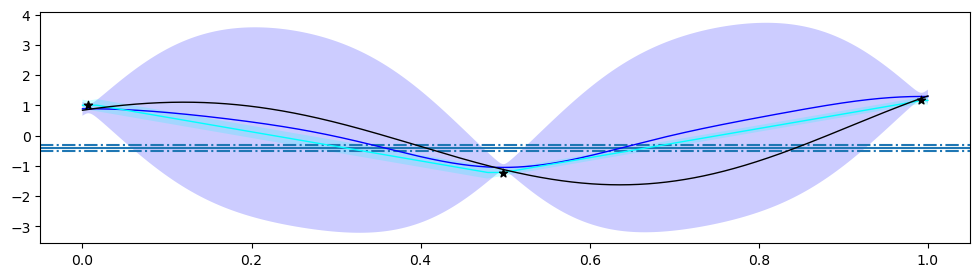

In [19]:
fig, ax = plt.subplots(figsize = (12,3))
ax.plot(test, forward.predict(test), 'black', lw = 1, label = "Ground truth", zorder = 8)

ax.scatter(x, y, color = 'black', marker = '*', label = 'Lipschitz training points', zorder = 10)
#ax.scatter(x, train_y, color = 'red', marker = '*', label = 'GP training points', zorder = 10)
plt.axhline(meas)
plt.axhline(meas + 2 * eps_l, linestyle="dashdot")
plt.axhline(meas - 2 * eps_l, linestyle="dashdot")

ax.plot(test, mean, 'blue', lw = 1, label="GP predictive mean and \n 95% confidence interval")
ax.fill_between(
    test.ravel(),
    np.reshape(mean - 1.96 * std, -1),
    np.reshape(mean + 1.96 * std, -1),
    alpha=0.2,
    label="GP predictive mean and \n 95% confidence interval",
    facecolor= 'blue'
)

ax.plot(test, pred, 'cyan', lw = 1, label ="Lipschitz prediction and \n confidence interval")
ax.fill_between(
    test.ravel(),
    low_bd[:,0],
    up_bd[:,0],
    alpha=0.2,
    label="Lipschitz prediction and \n confidence interval",
    facecolor= 'cyan'
)
# handler, labeler = ax.get_legend_handles_labels()
# hd = [(handler[0],), (handler[1],),
#       (handler[2],handler[3]), 
#       (handler[4],handler[5]),
#      ]
# lab = ["Ground truth", 'Training points',"GP predictive mean and \n 95% confidence interval", "Lipschitz prediction and \n confidence interval", ]
# ax.legend(hd, lab, )
    #loc = 'upper right', prop={'size': 16} )
#fig.savefig("model_comparison.svg", format = 'svg', transparent = True)


In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
from likelihoods.likelihoods import lipschitz_likelihood, GP_likelihood

In [22]:
liplike = lipschitz_likelihood(meas, eps_l**2, lips)
GPlike = GP_likelihood(meas, eps_l**2, GP)

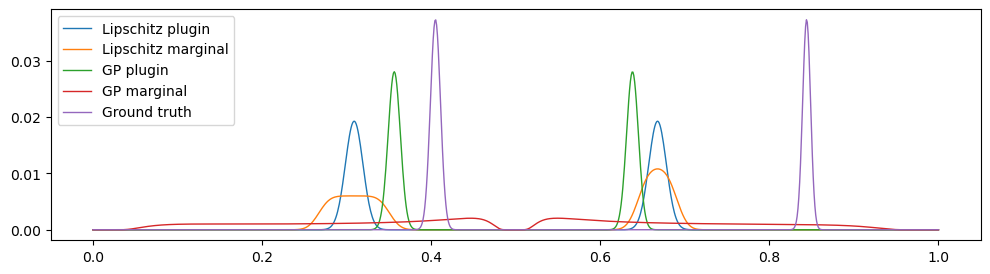

In [23]:
fig, ax = plt.subplots(figsize = (12,3))
lip_plugin = liplike.plugin(test)
lip_plugin /= lip_plugin.sum()
ax.plot(test, lip_plugin, lw = 1, label = "Lipschitz plugin")
lip_marginal = liplike.marginal(test)
lip_marginal /= lip_marginal.sum()
ax.plot(test, lip_marginal, lw = 1, label = "Lipschitz marginal")
GP_plugin = GPlike.plugin(x_test)
GP_plugin /= GP_plugin.sum()
ax.plot(test, GP_plugin, lw = 1, label = "GP plugin")
GP_marginal = GPlike.marginal(x_test)
GP_marginal /= GP_marginal.sum()
ax.plot(test, GP_marginal, lw = 1, label = "GP marginal")
GPlike.model = forward
truth = GPlike.plugin(test)
truth /= truth.sum()
ax.plot(test, truth, lw = 1, label = "Ground truth")
plt.legend()

In [487]:
pred.shape

(1000, 1)

In [254]:
x.shape

(7, 1)

In [265]:
x2 =x**2
np.sqrt(x2 + x2.transpose() - 2 *x.dot(x.transpose() ))

array([[0.        , 0.14582016, 0.82483628, 0.3445717 , 0.1467745 ,
        0.49744671, 0.64878762],
       [0.14582016, 0.        , 0.67901612, 0.19875154, 0.29259466,
        0.35162655, 0.50296746],
       [0.82483628, 0.67901612, 0.        , 0.48026458, 0.97161078,
        0.32738957, 0.17604866],
       [0.3445717 , 0.19875154, 0.48026458, 0.        , 0.4913462 ,
        0.15287501, 0.30421592],
       [0.1467745 , 0.29259466, 0.97161078, 0.4913462 , 0.        ,
        0.64422121, 0.79556212],
       [0.49744671, 0.35162655, 0.32738957, 0.15287501, 0.64422121,
        0.        , 0.15134091],
       [0.64878762, 0.50296746, 0.17604866, 0.30421592, 0.79556212,
        0.15134091, 0.        ]])

In [260]:
from scipy.spatial.distance import cdist
cdist(x,x)

array([[0.        , 0.14582016, 0.82483628, 0.3445717 , 0.1467745 ,
        0.49744671, 0.64878762],
       [0.14582016, 0.        , 0.67901612, 0.19875154, 0.29259466,
        0.35162655, 0.50296746],
       [0.82483628, 0.67901612, 0.        , 0.48026458, 0.97161078,
        0.32738957, 0.17604866],
       [0.3445717 , 0.19875154, 0.48026458, 0.        , 0.4913462 ,
        0.15287501, 0.30421592],
       [0.1467745 , 0.29259466, 0.97161078, 0.4913462 , 0.        ,
        0.64422121, 0.79556212],
       [0.49744671, 0.35162655, 0.32738957, 0.15287501, 0.64422121,
        0.        , 0.15134091],
       [0.64878762, 0.50296746, 0.17604866, 0.30421592, 0.79556212,
        0.15134091, 0.        ]])

In [266]:
dy = y.reshape( (len(y[0]), -1, len(y) ))

In [283]:
y2 =dy**2
np.sqrt(y2 + y2.transpose((0,2,1)) - 2 *dy.transpose((0,2,1) ).dot(dy )[:,:,0,:])

array([[[0.        , 1.37070077, 1.07291481, 0.66844719, 1.79077538,
         1.79600814, 0.19392787],
        [1.37070077, 0.        , 0.29778596, 0.70225358, 0.42007461,
         0.42530736, 1.1767729 ],
        [1.07291481, 0.29778596, 0.        , 0.40446763, 0.71786057,
         0.72309332, 0.87898694],
        [0.66844719, 0.70225358, 0.40446763, 0.        , 1.1223282 ,
         1.12756095, 0.47451931],
        [1.79077538, 0.42007461, 0.71786057, 1.1223282 , 0.        ,
         0.00523275, 1.59684751],
        [1.79600814, 0.42530736, 0.72309332, 1.12756095, 0.00523275,
         0.        , 1.60208026],
        [0.19392787, 1.1767729 , 0.87898694, 0.47451931, 1.59684751,
         1.60208026, 0.        ]]])

In [285]:
dy.transpose((0,2,1) ).dot(y.transpose() ).shape

(1, 7, 7)

In [276]:
dy.shape

(1, 1, 7)

In [286]:
dx = x.reshape((len(x[0]), -1, len(x) ))
dx.transpose((0,2,1) ).dot(x.transpose() ).shape

(1, 7, 7)

In [101]:
x = lhs( 0, 1, 5).reshape((-1,1))

In [102]:
forward = fm(1, "U")
true = forward.predict(x)

In [103]:
noise = np.ones_like(true) * 0.05
y = np.random.uniform(true-noise,true+ noise)
noise0 = noise

In [109]:
nx =  lhs( 0.2, 0.8, 5).reshape((-1,1))
ny, _ = forward.predict(nx, noise0)
noise = np.concatenate( (noise, noise0) )

In [110]:
x = np.concatenate( (x,nx) )
y = np.concatenate( (y,ny) )

In [111]:
x2 = np.sum(x**2, axis = 1, keepdims=True)
xxT = x.dot(x.transpose())
dist_x = np.sqrt( x2 + x2.transpose() - 2 *xxT )

yT=y.transpose()

yT = yT.reshape( (len(yT), len(yT[0]), -1 ))

dist_y = np.abs(yT - yT.transpose((0,2,1)))

In [112]:
true_dist_x = np.zeros_like(dist_x)
true_dist_y = np.zeros_like(dist_y)
for i in range(3) :
    for j in range(3) :
        true_dist_x[i,j] = np.linalg.norm(x[i]-x[j])
        true_dist_y[:,i,j] = np.abs(y[i] - y[j] )

In [113]:
eps = noise.reshape((len(y), -1))
eps2 = (eps + eps.transpose())

L_mat = (dist_y )/dist_x - eps2/dist_x

L = np.nanmax(L_mat, axis=(1,2), )
L

/tmp/ipykernel_3344935/3012233647.py:4: RuntimeWarning: invalid value encountered in divide
  L_mat = (dist_y )/dist_x - eps2/dist_x
/tmp/ipykernel_3344935/3012233647.py:4: RuntimeWarning: divide by zero encountered in divide
  L_mat = (dist_y )/dist_x - eps2/dist_x


array([2.82148987])

In [114]:
true_dist_y

array([[[0.        , 0.74928437, 0.74418425, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.74928437, 0.        , 1.49346863, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.74418425, 1.49346863, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.       

In [115]:
dist_y

array([[[0.        , 0.74928437, 0.74418425, 1.05450177, 0.54279282,
         0.78764701, 0.71221035, 0.43681238, 0.40007584, 0.00865424,
         0.8080359 , 0.33114869, 0.020482  , 0.66734173, 0.49752757],
        [0.74928437, 0.        , 1.49346863, 0.30521739, 1.29207719,
         0.03836263, 1.46149473, 0.312472  , 1.14936021, 0.74063013,
         0.05875152, 1.08043306, 0.72880237, 1.4166261 , 0.2517568 ],
        [0.74418425, 1.49346863, 0.        , 1.79868602, 0.20139143,
         1.53183126, 0.0319739 , 1.18099663, 0.34410841, 0.75283849,
         1.55222015, 0.41303556, 0.76466625, 0.07684253, 1.24171182],
        [1.05450177, 0.30521739, 1.79868602, 0.        , 1.59729459,
         0.26685476, 1.76671212, 0.61768939, 1.45457761, 1.04584753,
         0.24646587, 1.38565046, 1.03401977, 1.72184349, 0.5569742 ],
        [0.54279282, 1.29207719, 0.20139143, 1.59729459, 0.        ,
         1.33043983, 0.16941753, 0.9796052 , 0.14271698, 0.55144706,
         1.35082872, 0.2116441

In [57]:
noise = np.concatenate( (noise, noise) )

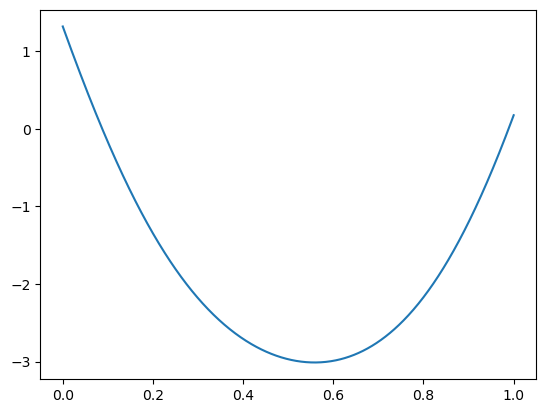

In [116]:
t = np.linspace(0,1,1000)
f = (2*t-1) *np.sin(4*t+1) + 4 * (1-t+t**2) * np.cos(4*t+1)
plt.plot(t,f)

In [122]:
intf = np.array( [ np.sum(f[:i])/len(f) for i in range(len(f) ) ] )

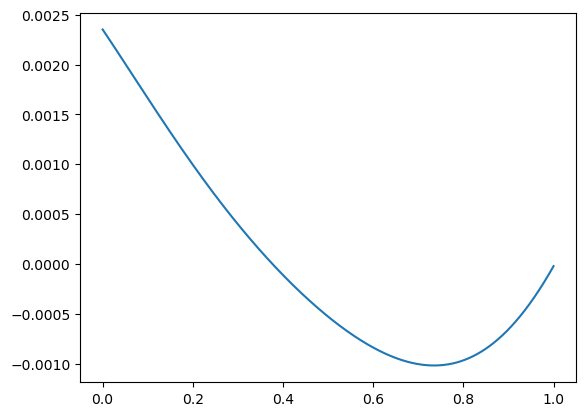

In [129]:
err = forward.predict(t).reshape(-1) - intf
err -= err.mean()
plt.plot(t, err  )

In [130]:
from scipy.stats import norm

In [225]:
tau = 4

def D(s) :
    upper_term = 2*norm.cdf(-tau/s) 

    discr = np.linspace(-tau, tau, 3000).reshape((1,-1))
    sT = s.reshape( (-1,1) )

    diff = np.abs( 0.5/tau - 1/ sT * norm.pdf(discr/sT) )
    
    lower_term = 2*tau * np.mean( diff, axis = 1)
    return upper_term + lower_term

In [226]:
t = np.linspace(0.1, 5, 2000)

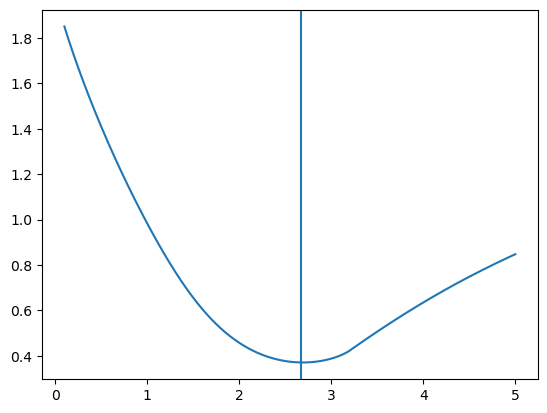

In [227]:
plt.plot(t, D(t) )
plt.axvline(tau*2/3)

In [224]:
a = np.argmin(D(t) )
t[a]

2.6909454727363684

In [119]:
x = np.array([[0.0]])
y = np.array([[0.0]])
eps = 0.1
noise = np.array([[eps]])
lips = lipschitz_regressor(x, y, noise)
lips.L = np.array([1])

C:\Users/paolo/projects/thesis/code\models\lipschitz.py:69: RuntimeWarning: invalid value encountered in divide
  L_mat = (dist_y )/dist_x - eps2/dist_x
C:\Users/paolo/projects/thesis/code\models\lipschitz.py:69: RuntimeWarning: divide by zero encountered in divide
  L_mat = (dist_y )/dist_x - eps2/dist_x
C:\Users/paolo/projects/thesis/code\models\lipschitz.py:71: RuntimeWarning: All-NaN slice encountered
  L = np.nanmax(L_mat, axis = (1,2) )*1.1


In [120]:
p = np.array([[1.0]])
_, LB, UB = lips.predict(p, return_bds=True)

In [121]:
from copy import deepcopy

In [157]:
discr_ep = np.linspace(-eps, eps,100)
discr_pr =np.linspace(LB, UB, 100)

q = np.array([[0.5]])
_, _, UBq = lips.predict(q, return_bds=True)

integ = 0
for ep in discr_ep :
    for pr in discr_pr :
        lips1 = deepcopy(lips)
        lips1.update(p, pr+ep, noise)
        _, _, nUBq =  lips1.predict(q, return_bds=True)

        integ += np.max([[[0]], UBq-nUBq])/40000

C:\Users/paolo/projects/thesis/code\models\lipschitz.py:69: RuntimeWarning: invalid value encountered in divide
  L_mat = (dist_y )/dist_x - eps2/dist_x
C:\Users/paolo/projects/thesis/code\models\lipschitz.py:69: RuntimeWarning: divide by zero encountered in divide
  L_mat = (dist_y )/dist_x - eps2/dist_x


In [158]:
pr+ep

array([[1.2]])

In [159]:
UBq-nUBq

array([[-0.05]])

In [160]:
integ

0.14559180555555543

In [143]:
alpha = UBq-(p-q)-eps

In [144]:
alpha

array([[-2.77555756e-17]])

In [131]:
eps

0.1

In [164]:
1/6*(eps**3 + eps*(alpha - LB))

array([[0.0185]])

In [165]:
integ * (2*eps) *(UB-LB)

array([[0.19218118]])

In [155]:
alpha

array([[-2.77555756e-17]])

In [141]:
UBq

array([[0.6]])

In [156]:
eps * ( LB - alpha + eps) * (-LB + alpha + eps) + (2*eps)**3/6

array([[-0.11866667]])